<a href="https://colab.research.google.com/github/SanthanamP/covid-19-symptoms-presence/blob/main/CycleGAN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import os
import pathlib
import time
import datetime
import imageio
from glob import glob
import keras
import cv2
import re
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import Model, losses, optimizers
import numpy as np 
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import tensorflow_datasets as tfds


from matplotlib import pyplot as plt
from IPython import display
from termcolor import colored
from tqdm import tqdm
from IPython.display import Image
import PIL
from PIL import ImageDraw
from IPython import display
import concurrent.futures

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
ct_images = glob("/content/drive/MyDrive/Thesis/Patient%20Data/*/ct.jpg" )
mr_images= glob("/content/drive/MyDrive/Thesis/Patient%20Data/*/mri.jpg" )

In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test=train_test_split(ct_images,mr_images, test_size=0.2)

In [34]:
print(len(X_train))
print(len(y_train))

30
30


In [35]:
IMSIZE = 256
def read_img(image):
    img = tf.keras.preprocessing.image.load_img(image, color_mode='rgb', target_size=(IMSIZE, IMSIZE))
    return img
def prepare_dataset(namelist):
    start = time.time()
    imgs = []
    with concurrent.futures.ThreadPoolExecutor(max_workers = 16) as executor:
        i = 0
        for value in executor.map(read_img, namelist):
            i+=1
            print("\rFetching: [{}/{}]".format(i, len(namelist)), end="", flush=True)
            imgs.append(value)
        imgs = np.stack(imgs)
        imgs = tf.convert_to_tensor(imgs)
    print("\nExecution time: ",time.time() - start, "s")
    return imgs

In [36]:
with tf.device('/cpu:0'):
 
  train_a= prepare_dataset(X_train)
  train_b= prepare_dataset(y_train)
  test_a= prepare_dataset(X_test)
  test_b= prepare_dataset(y_test)
print("Training A tensor shape", train_a.shape)
print("Training B tensor shape", train_b.shape)
print("Testing A tensor shape", test_a.shape)
print("Testing B tensor shape", test_b.shape)

Fetching: [30/30]
Execution time:  0.22371959686279297 s
Fetching: [30/30]
Execution time:  0.21376323699951172 s
Fetching: [8/8]
Execution time:  0.06610608100891113 s
Fetching: [8/8]
Execution time:  0.07385420799255371 s
Training A tensor shape (30, 256, 256, 3)
Training B tensor shape (30, 256, 256, 3)
Testing A tensor shape (8, 256, 256, 3)
Testing B tensor shape (8, 256, 256, 3)


In [37]:
def map(image):

    image = tf.cast(image, tf.float32)
    image = image / 255
    image = image * 2 - 1
    
    return image

In [38]:
train_a = tf.data.Dataset.from_tensor_slices(train_a)
train_b = tf.data.Dataset.from_tensor_slices(train_b)
test_a = tf.data.Dataset.from_tensor_slices(test_a)
test_b = tf.data.Dataset.from_tensor_slices(test_b)

In [39]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 100

train_a = train_a.map(map, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
train_b = train_b.map(map, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
test_a = test_a.map(map, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
test_b = test_b.map(map, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)

In [40]:
train_dataset = tf.data.Dataset.zip((train_a, train_b))
test_dataset = tf.data.Dataset.zip((test_a, test_b))

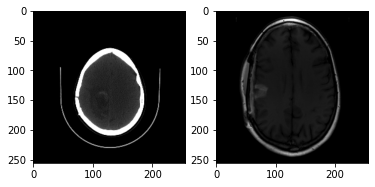

In [41]:
plt.figure(figsize=(6, 3))
for imgs_A, imgs_B in test_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow((imgs_A[0]+1)/2)
    plt.subplot(1,2,2)
    plt.imshow((imgs_B[0]+1)/2)

In [55]:
OUTPUT_CHANNELS = 3


def downsample(filters, size, apply_batchnorm=True):
#    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               use_bias=False))

    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
#    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        use_bias=False))

    result.add(tfa.layers.InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

#    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [56]:
generator_x = Generator()   # a——>o
generator_y = Generator()   # o——>a
#tf.keras.utils.plot_model(generator_x, show_shapes=True, dpi=64)

In [57]:
def Discriminator():
#    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    down1 = downsample(64, 4, False)(inp) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
               512, 4, strides=1,use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
               1, 4, strides=1)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [58]:
discriminator_x = Discriminator()   # discriminator  a
discriminator_y = Discriminator()   # discriminator  o
#tf.keras.utils.plot_model(discriminator_x, show_shapes=True, dpi=64)

In [59]:
for example_input, example_target in test_dataset.take(1):
    pass

In [60]:
def image_show():
    
    title=['Source domain','Target domain','Map']
    rendered_pictures = generator_x(example_input, training=False)
    rendered_picture = rendered_pictures[0]
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1,3,1)
    plt.imshow((example_input[0].numpy()+1)/2)
    plt.title(title[0])
    plt.subplot(1,3,2)
    plt.imshow((example_target[0].numpy()+1)/2)       
    plt.title(title[1])
    plt.subplot(1,3,3)
    plt.imshow((rendered_picture.numpy()+1)/2)
    plt.title(title[2])
    plt.show()
    
    return rendered_pictures

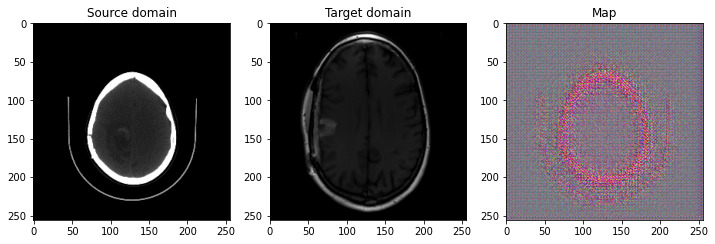

In [61]:
pred = image_show()

In [62]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 7

def discriminator_loss(disc_real_output, disc_fake_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_fake_output), disc_fake_output)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss


def generator_loss(disc_fake_output):
    gen_loss = loss_object(tf.ones_like(disc_fake_output), disc_fake_output)
    return gen_loss


def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

In [63]:
generator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [64]:
@tf.function
def train_discriminator(image_a, image_b):
    with tf.GradientTape(persistent=True) as discriminator_tape:
        #A->B->A
        fake_b = generator_x(image_a, training=True)
        cycled_a = generator_y(fake_b, training=True)
        #B->A->B
        fake_a = generator_y(image_b, training=True)
        cycled_b = generator_x(fake_a, training=True)
        #计算discriminator输出
        disc_real_a = discriminator_x(image_a, training=True)
        disc_real_b = discriminator_y(image_b, training=True)
        disc_fake_a = discriminator_x(fake_a, training=True)
        disc_fake_b = discriminator_y(fake_b, training=True)

        discriminator_x_loss = discriminator_loss(disc_real_a, disc_fake_a)
        discriminator_y_loss = discriminator_loss(disc_real_b, disc_fake_b)
        
    discriminator_x_gradients = discriminator_tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = discriminator_tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,discriminator_y.trainable_variables))

In [65]:
@tf.function
def train_generator(image_a, image_b):
    with tf.GradientTape(persistent=True) as generator_tape:
        #A->B->A
        fake_b = generator_x(image_a, training=True)
        cycled_a = generator_y(fake_b, training=True)
        #B->A->B
        fake_a = generator_y(image_b, training=True)
        cycled_b = generator_x(fake_a, training=True)
        #计算discriminator输出
        disc_fake_a = discriminator_x(fake_a, training=True)
        disc_fake_b = discriminator_y(fake_b, training=True)

        gen_x_loss = generator_loss(disc_fake_b)
        gen_y_loss = generator_loss(disc_fake_a)
        
        total_cycle_loss = calc_cycle_loss(image_a, cycled_a) + calc_cycle_loss(image_b, cycled_b)
        
        total_gen_x_loss = gen_x_loss + total_cycle_loss
        total_gen_y_loss = gen_y_loss + total_cycle_loss
        
    generator_x_gradients = generator_tape.gradient(total_gen_x_loss, generator_x.trainable_variables)
    generator_y_gradients = generator_tape.gradient(total_gen_y_loss, generator_y.trainable_variables)
    
    generator_x_optimizer.apply_gradients(zip(generator_x_gradients, generator_x.trainable_variables))
    generator_y_optimizer.apply_gradients(zip(generator_y_gradients, generator_y.trainable_variables))

In [68]:
Epochs = 200


Epoch 1/200 
Training: [--------->] 100 %  - 10 s

Epoch 2/200 
Training: [--------->] 100 %  - 10 s

Epoch 3/200 
Training: [--------->] 100 %  - 10 s

Epoch 4/200 
Training: [--------->] 100 %  - 10 s

Epoch 5/200 
Training: [--------->] 100 %  - 10 s


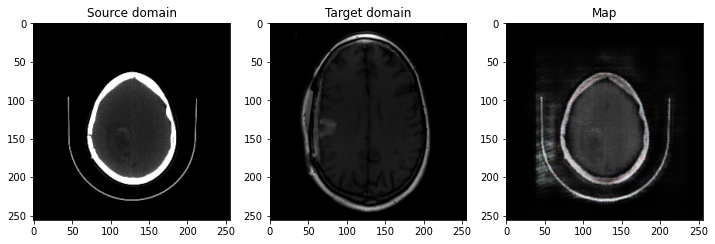


Epoch 6/200 
Training: [--------->] 100 %  - 10 s

Epoch 7/200 
Training: [--------->] 100 %  - 10 s

Epoch 8/200 
Training: [--------->] 100 %  - 10 s

Epoch 9/200 
Training: [--------->] 100 %  - 10 s

Epoch 10/200 
Training: [--------->] 100 %  - 10 s


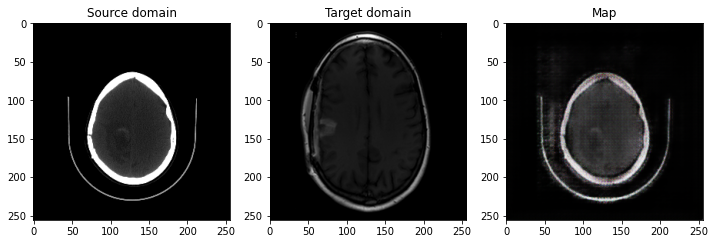


Epoch 11/200 
Training: [--------->] 100 %  - 10 s

Epoch 12/200 
Training: [--------->] 100 %  - 10 s

Epoch 13/200 
Training: [--------->] 100 %  - 10 s

Epoch 14/200 
Training: [--------->] 100 %  - 10 s

Epoch 15/200 
Training: [--------->] 100 %  - 10 s


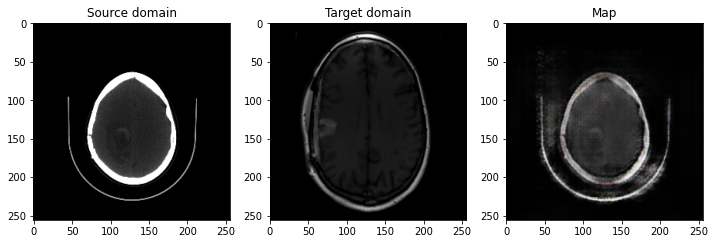


Epoch 16/200 
Training: [--------->] 100 %  - 10 s

Epoch 17/200 
Training: [--------->] 100 %  - 10 s

Epoch 18/200 
Training: [--------->] 100 %  - 10 s

Epoch 19/200 
Training: [--------->] 100 %  - 10 s

Epoch 20/200 
Training: [--------->] 100 %  - 10 s


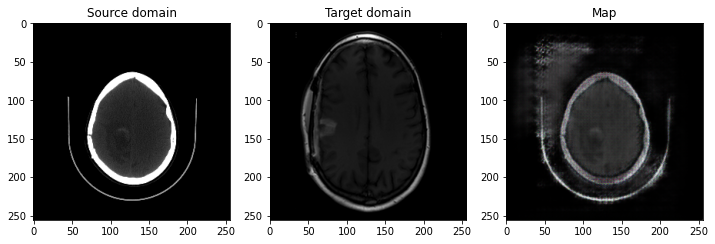


Epoch 21/200 
Training: [--------->] 100 %  - 10 s

Epoch 22/200 
Training: [--------->] 100 %  - 10 s

Epoch 23/200 
Training: [--------->] 100 %  - 10 s

Epoch 24/200 
Training: [--------->] 100 %  - 10 s

Epoch 25/200 
Training: [--------->] 100 %  - 10 s


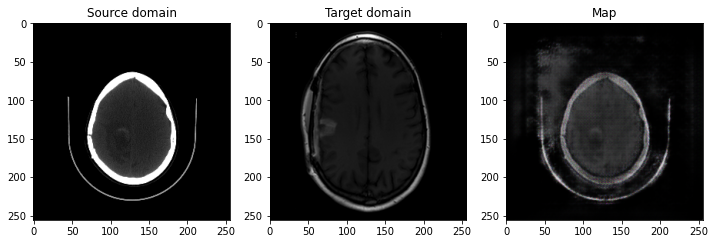


Epoch 26/200 
Training: [--------->] 100 %  - 10 s

Epoch 27/200 
Training: [--------->] 100 %  - 10 s

Epoch 28/200 
Training: [--------->] 100 %  - 10 s

Epoch 29/200 
Training: [--------->] 100 %  - 10 s

Epoch 30/200 
Training: [--------->] 100 %  - 10 s


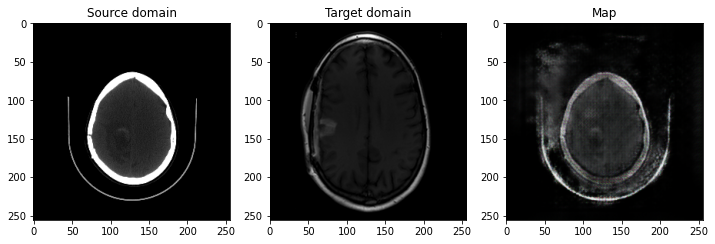


Epoch 31/200 
Training: [--------->] 100 %  - 10 s

Epoch 32/200 
Training: [--------->] 100 %  - 10 s

Epoch 33/200 
Training: [--------->] 100 %  - 10 s

Epoch 34/200 
Training: [--------->] 100 %  - 10 s

Epoch 35/200 
Training: [--------->] 100 %  - 10 s


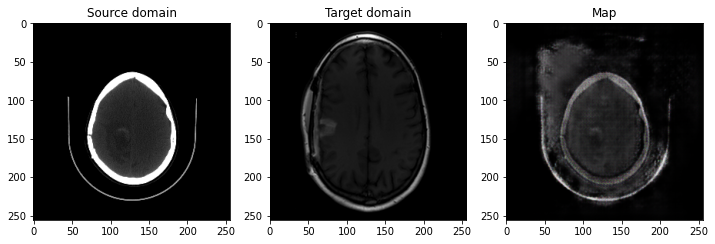


Epoch 36/200 
Training: [--------->] 100 %  - 10 s

Epoch 37/200 
Training: [--------->] 100 %  - 10 s

Epoch 38/200 
Training: [--------->] 100 %  - 10 s

Epoch 39/200 
Training: [--------->] 100 %  - 10 s

Epoch 40/200 
Training: [--------->] 100 %  - 10 s


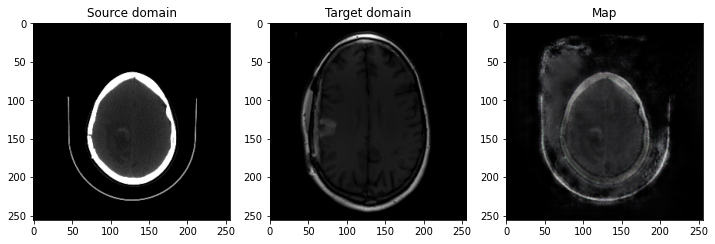


Epoch 41/200 
Training: [--------->] 100 %  - 10 s

Epoch 42/200 
Training: [--------->] 100 %  - 10 s

Epoch 43/200 
Training: [--------->] 100 %  - 10 s

Epoch 44/200 
Training: [--------->] 100 %  - 10 s

Epoch 45/200 
Training: [--------->] 100 %  - 10 s


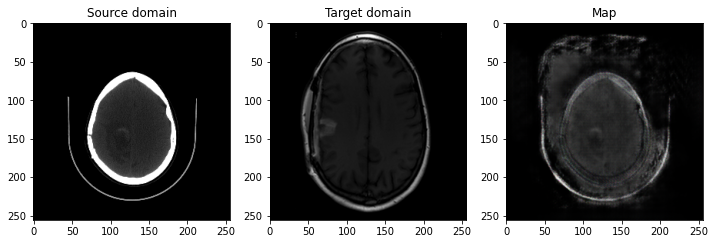


Epoch 46/200 
Training: [--------->] 100 %  - 10 s

Epoch 47/200 
Training: [--------->] 100 %  - 10 s

Epoch 48/200 
Training: [--------->] 100 %  - 10 s

Epoch 49/200 
Training: [--------->] 100 %  - 10 s

Epoch 50/200 
Training: [--------->] 100 %  - 10 s


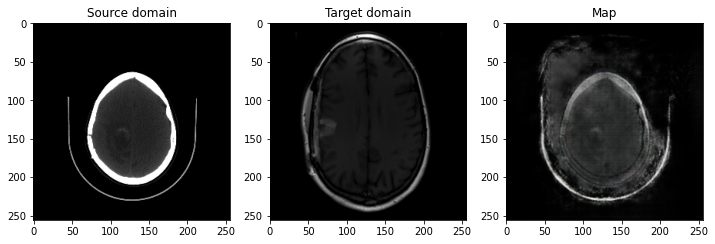


Epoch 51/200 
Training: [--------->] 100 %  - 10 s

Epoch 52/200 
Training: [--------->] 100 %  - 10 s

Epoch 53/200 
Training: [--------->] 100 %  - 10 s

Epoch 54/200 
Training: [--------->] 100 %  - 10 s

Epoch 55/200 
Training: [--------->] 100 %  - 10 s


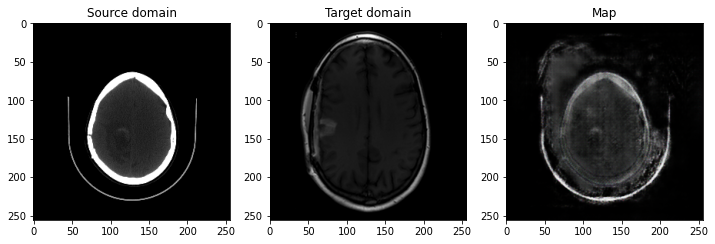


Epoch 56/200 
Training: [--------->] 100 %  - 10 s

Epoch 57/200 
Training: [--------->] 100 %  - 10 s

Epoch 58/200 
Training: [--------->] 100 %  - 10 s

Epoch 59/200 
Training: [--------->] 100 %  - 10 s

Epoch 60/200 
Training: [--------->] 100 %  - 10 s


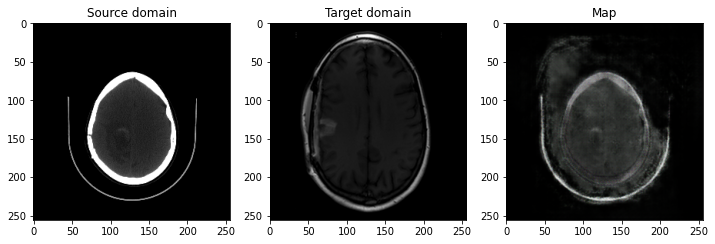


Epoch 61/200 
Training: [--------->] 100 %  - 10 s

Epoch 62/200 
Training: [--------->] 100 %  - 10 s

Epoch 63/200 
Training: [--------->] 100 %  - 10 s

Epoch 64/200 
Training: [--------->] 100 %  - 10 s

Epoch 65/200 
Training: [--------->] 100 %  - 10 s


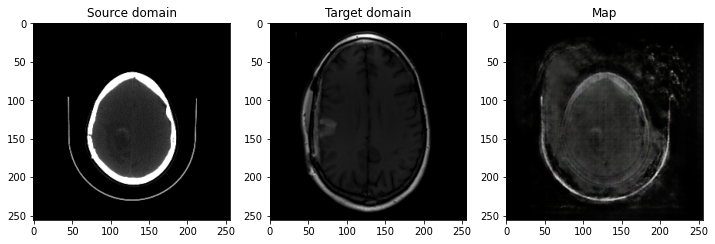


Epoch 66/200 
Training: [--------->] 100 %  - 10 s

Epoch 67/200 
Training: [--------->] 100 %  - 10 s

Epoch 68/200 
Training: [--------->] 100 %  - 10 s

Epoch 69/200 
Training: [--------->] 100 %  - 10 s

Epoch 70/200 
Training: [--------->] 100 %  - 10 s


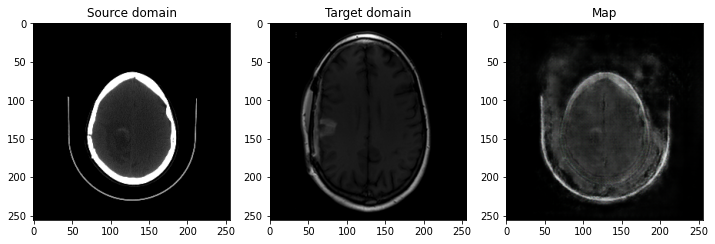


Epoch 71/200 
Training: [--------->] 100 %  - 10 s

Epoch 72/200 
Training: [--------->] 100 %  - 10 s

Epoch 73/200 
Training: [--------->] 100 %  - 10 s

Epoch 74/200 
Training: [--------->] 100 %  - 10 s

Epoch 75/200 
Training: [--------->] 100 %  - 10 s


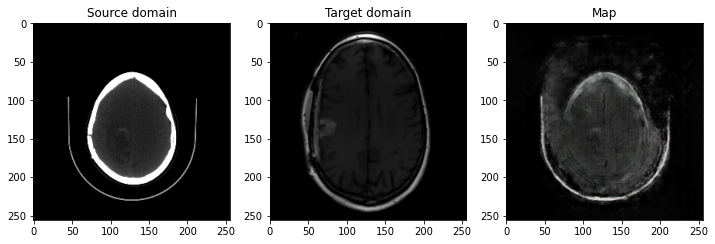


Epoch 76/200 
Training: [--------->] 100 %  - 10 s

Epoch 77/200 
Training: [--------->] 100 %  - 10 s

Epoch 78/200 
Training: [--------->] 100 %  - 10 s

Epoch 79/200 
Training: [--------->] 100 %  - 10 s

Epoch 80/200 
Training: [--------->] 100 %  - 10 s


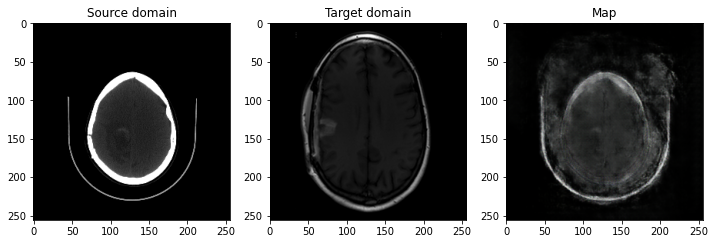


Epoch 81/200 
Training: [--------->] 100 %  - 10 s

Epoch 82/200 
Training: [--------->] 100 %  - 10 s

Epoch 83/200 
Training: [--------->] 100 %  - 10 s

Epoch 84/200 
Training: [--------->] 100 %  - 10 s

Epoch 85/200 
Training: [--------->] 100 %  - 10 s


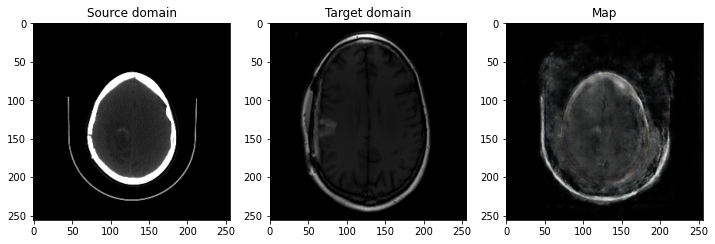


Epoch 86/200 
Training: [--------->] 100 %  - 9 s

Epoch 87/200 
Training: [--------->] 100 %  - 10 s

Epoch 88/200 
Training: [--------->] 100 %  - 10 s

Epoch 89/200 
Training: [--------->] 100 %  - 10 s

Epoch 90/200 
Training: [--------->] 100 %  - 10 s


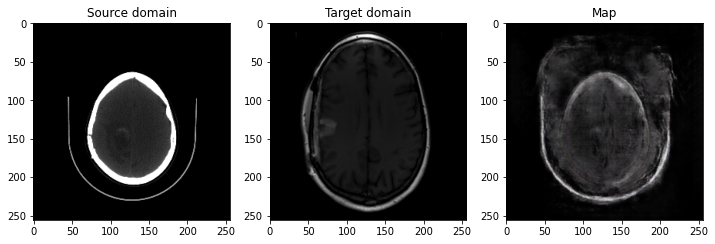


Epoch 91/200 
Training: [--------->] 100 %  - 10 s

Epoch 92/200 
Training: [--------->] 100 %  - 10 s

Epoch 93/200 
Training: [--------->] 100 %  - 10 s

Epoch 94/200 
Training: [--------->] 100 %  - 10 s

Epoch 95/200 
Training: [--------->] 100 %  - 10 s


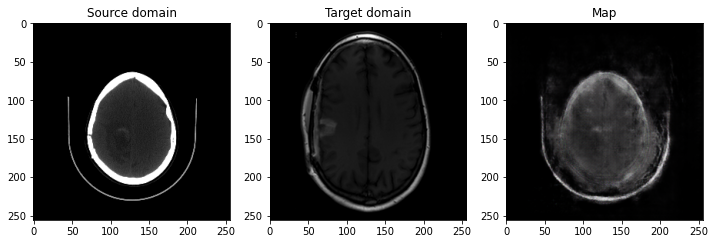


Epoch 96/200 
Training: [--------->] 100 %  - 10 s

Epoch 97/200 
Training: [--------->] 100 %  - 10 s

Epoch 98/200 
Training: [--------->] 100 %  - 10 s

Epoch 99/200 
Training: [--------->] 100 %  - 10 s

Epoch 100/200 
Training: [--------->] 100 %  - 10 s


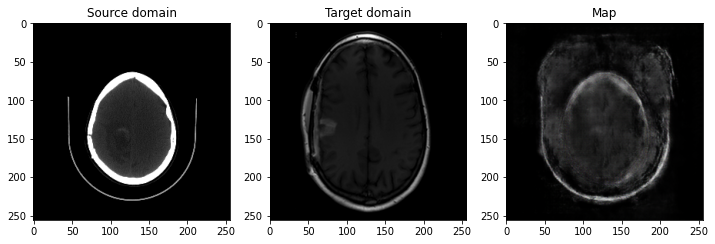


Epoch 101/200 
Training: [--------->] 100 %  - 10 s

Epoch 102/200 
Training: [--------->] 100 %  - 10 s

Epoch 103/200 
Training: [--------->] 100 %  - 10 s

Epoch 104/200 
Training: [--------->] 100 %  - 10 s

Epoch 105/200 
Training: [--------->] 100 %  - 10 s


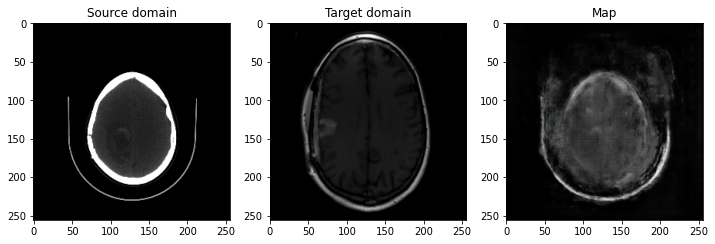


Epoch 106/200 
Training: [--------->] 100 %  - 10 s

Epoch 107/200 
Training: [--------->] 100 %  - 10 s

Epoch 108/200 
Training: [--------->] 100 %  - 10 s

Epoch 109/200 
Training: [--------->] 100 %  - 10 s

Epoch 110/200 
Training: [--------->] 100 %  - 10 s


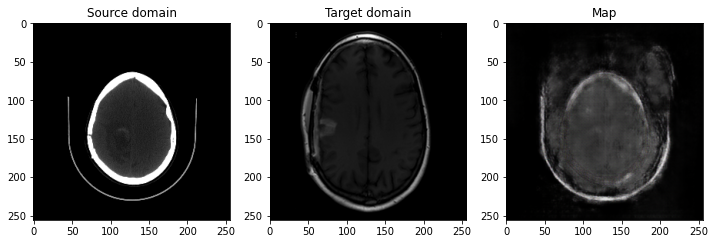


Epoch 111/200 
Training: [--------->] 100 %  - 10 s

Epoch 112/200 
Training: [--------->] 100 %  - 10 s

Epoch 113/200 
Training: [--------->] 100 %  - 10 s

Epoch 114/200 
Training: [--------->] 100 %  - 10 s

Epoch 115/200 
Training: [--------->] 100 %  - 10 s


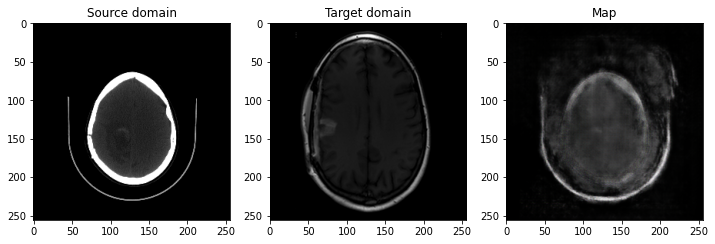


Epoch 116/200 
Training: [--------->] 100 %  - 10 s

Epoch 117/200 
Training: [--------->] 100 %  - 10 s

Epoch 118/200 
Training: [--------->] 100 %  - 10 s

Epoch 119/200 
Training: [--------->] 100 %  - 10 s

Epoch 120/200 
Training: [--------->] 100 %  - 10 s


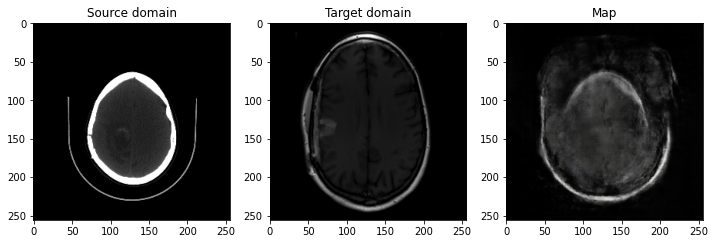


Epoch 121/200 
Training: [--------->] 100 %  - 10 s

Epoch 122/200 
Training: [--------->] 100 %  - 10 s

Epoch 123/200 
Training: [--------->] 100 %  - 10 s

Epoch 124/200 
Training: [--------->] 100 %  - 10 s

Epoch 125/200 
Training: [--------->] 100 %  - 10 s


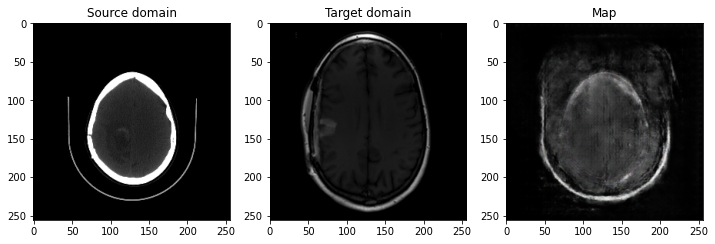


Epoch 126/200 
Training: [--------->] 100 %  - 9 s

Epoch 127/200 
Training: [--------->] 100 %  - 10 s

Epoch 128/200 
Training: [--------->] 100 %  - 10 s

Epoch 129/200 
Training: [--------->] 100 %  - 10 s

Epoch 130/200 
Training: [--------->] 100 %  - 10 s


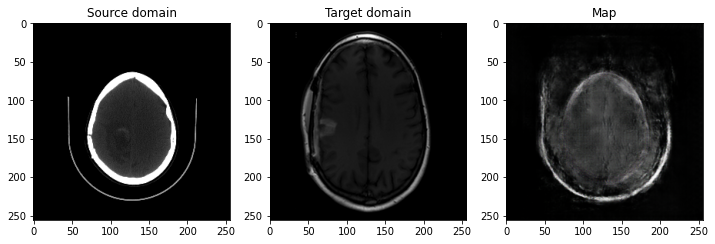


Epoch 131/200 
Training: [--------->] 100 %  - 10 s

Epoch 132/200 
Training: [--------->] 100 %  - 10 s

Epoch 133/200 
Training: [--------->] 100 %  - 10 s

Epoch 134/200 
Training: [--------->] 100 %  - 10 s

Epoch 135/200 
Training: [--------->] 100 %  - 10 s


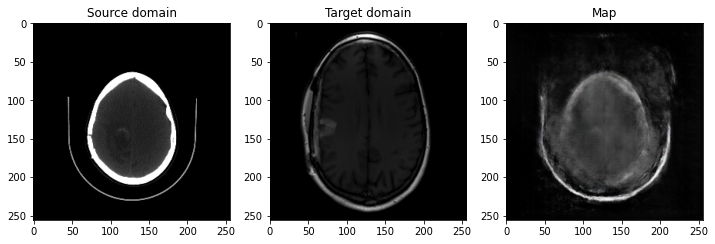


Epoch 136/200 
Training: [--------->] 100 %  - 9 s

Epoch 137/200 
Training: [--------->] 100 %  - 10 s

Epoch 138/200 
Training: [--------->] 100 %  - 10 s

Epoch 139/200 
Training: [--------->] 100 %  - 10 s

Epoch 140/200 
Training: [--------->] 100 %  - 10 s


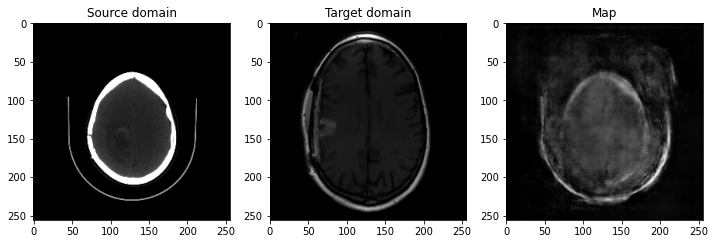


Epoch 141/200 
Training: [--------->] 100 %  - 10 s

Epoch 142/200 
Training: [--------->] 100 %  - 10 s

Epoch 143/200 
Training: [--------->] 100 %  - 10 s

Epoch 144/200 
Training: [--------->] 100 %  - 10 s

Epoch 145/200 
Training: [--------->] 100 %  - 10 s


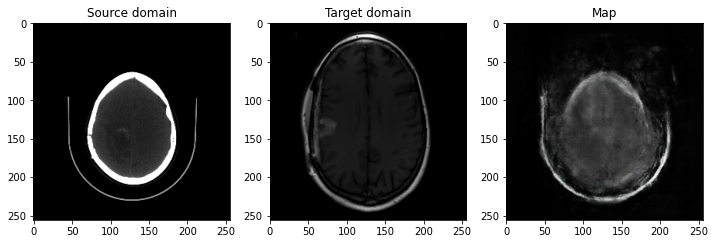


Epoch 146/200 
Training: [--------->] 100 %  - 10 s

Epoch 147/200 
Training: [--------->] 100 %  - 10 s

Epoch 148/200 
Training: [--------->] 100 %  - 10 s

Epoch 149/200 
Training: [--------->] 100 %  - 10 s

Epoch 150/200 
Training: [--------->] 100 %  - 10 s


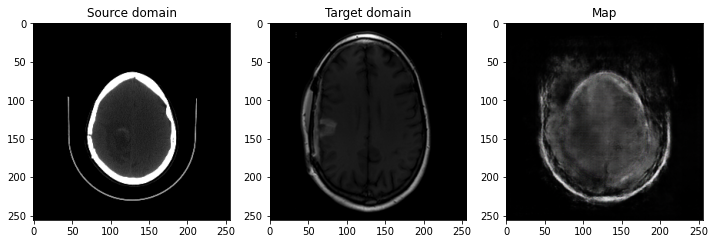


Epoch 151/200 
Training: [--------->] 100 %  - 10 s

Epoch 152/200 
Training: [--------->] 100 %  - 10 s

Epoch 153/200 
Training: [--------->] 100 %  - 10 s

Epoch 154/200 
Training: [--------->] 100 %  - 10 s

Epoch 155/200 
Training: [--------->] 100 %  - 10 s


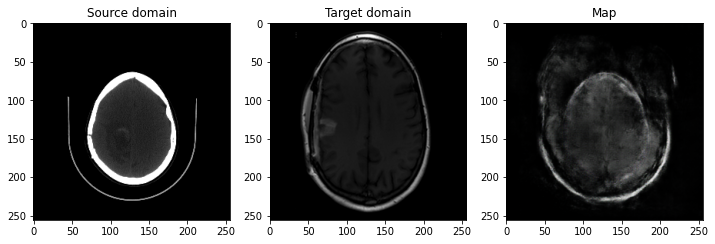


Epoch 156/200 
Training: [--------->] 100 %  - 9 s

Epoch 157/200 
Training: [--------->] 100 %  - 10 s

Epoch 158/200 
Training: [--------->] 100 %  - 10 s

Epoch 159/200 
Training: [--------->] 100 %  - 10 s

Epoch 160/200 
Training: [--------->] 100 %  - 10 s


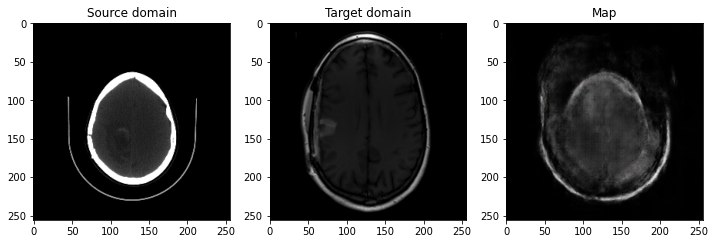


Epoch 161/200 
Training: [--------->] 100 %  - 10 s

Epoch 162/200 
Training: [--------->] 100 %  - 10 s

Epoch 163/200 
Training: [--------->] 100 %  - 10 s

Epoch 164/200 
Training: [--------->] 100 %  - 10 s

Epoch 165/200 
Training: [--------->] 100 %  - 10 s


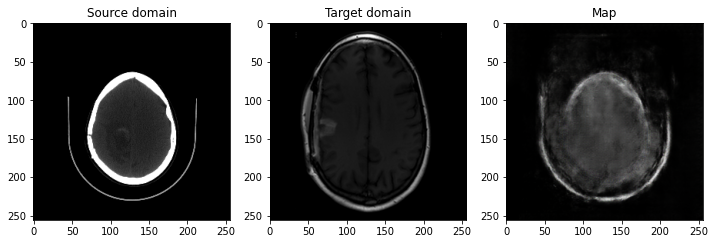


Epoch 166/200 
Training: [--------->] 100 %  - 10 s

Epoch 167/200 
Training: [--------->] 100 %  - 10 s

Epoch 168/200 
Training: [--------->] 100 %  - 10 s

Epoch 169/200 
Training: [--------->] 100 %  - 10 s

Epoch 170/200 
Training: [--------->] 100 %  - 10 s


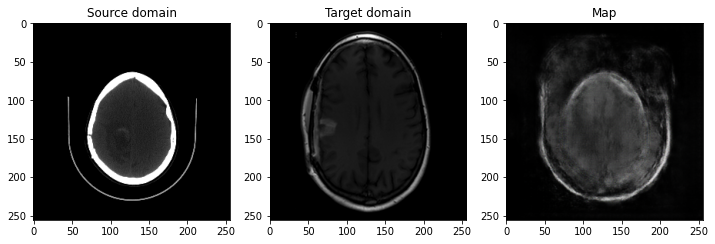


Epoch 171/200 
Training: [--------->] 100 %  - 10 s

Epoch 172/200 
Training: [--------->] 100 %  - 10 s

Epoch 173/200 
Training: [--------->] 100 %  - 10 s

Epoch 174/200 
Training: [--------->] 100 %  - 10 s

Epoch 175/200 
Training: [--------->] 100 %  - 10 s


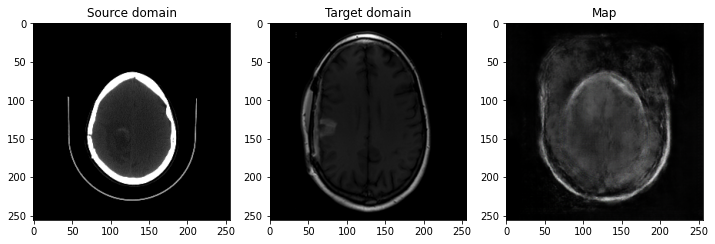


Epoch 176/200 
Training: [--------->] 100 %  - 10 s

Epoch 177/200 
Training: [--------->] 100 %  - 10 s

Epoch 178/200 
Training: [--------->] 100 %  - 10 s

Epoch 179/200 
Training: [--------->] 100 %  - 10 s

Epoch 180/200 
Training: [--------->] 100 %  - 10 s


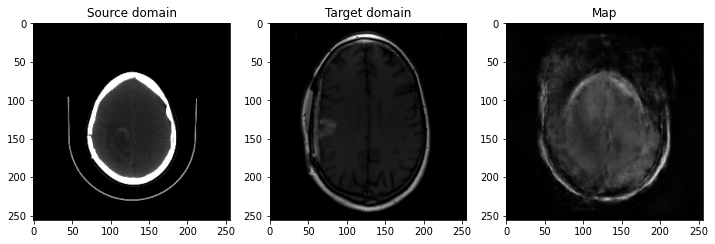


Epoch 181/200 
Training: [--------->] 100 %  - 10 s

Epoch 182/200 
Training: [--------->] 100 %  - 10 s

Epoch 183/200 
Training: [--------->] 100 %  - 10 s

Epoch 184/200 
Training: [--------->] 100 %  - 10 s

Epoch 185/200 
Training: [--------->] 100 %  - 10 s


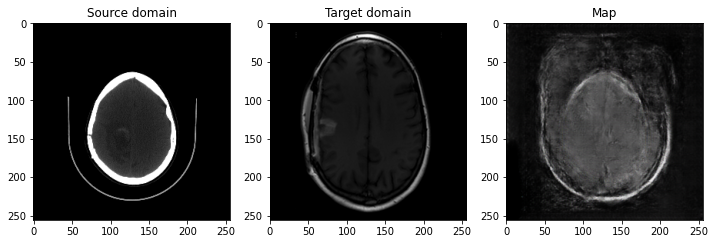


Epoch 186/200 
Training: [--------->] 100 %  - 10 s

Epoch 187/200 
Training: [--------->] 100 %  - 10 s

Epoch 188/200 
Training: [--------->] 100 %  - 10 s

Epoch 189/200 
Training: [--------->] 100 %  - 10 s

Epoch 190/200 
Training: [--------->] 100 %  - 10 s


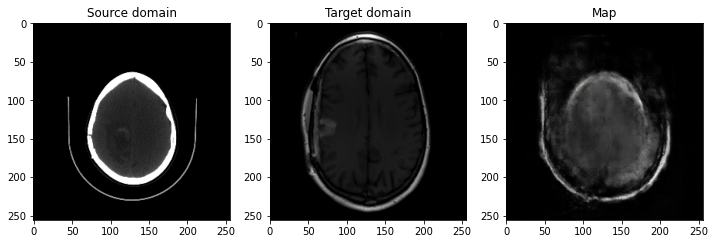


Epoch 191/200 
Training: [--------->] 100 %  - 10 s

Epoch 192/200 
Training: [--------->] 100 %  - 10 s

Epoch 193/200 
Training: [--------->] 100 %  - 10 s

Epoch 194/200 
Training: [--------->] 100 %  - 10 s

Epoch 195/200 
Training: [--------->] 100 %  - 10 s


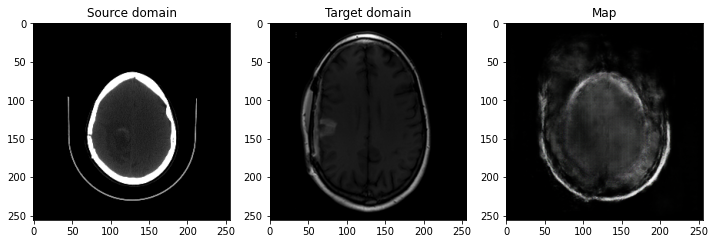


Epoch 196/200 
Training: [--------->] 100 %  - 10 s

Epoch 197/200 
Training: [--------->] 100 %  - 10 s

Epoch 198/200 
Training: [--------->] 100 %  - 10 s

Epoch 199/200 
Training: [--------->] 100 %  - 10 s

Epoch 200/200 
Training: [--------->] 100 %  - 10 s


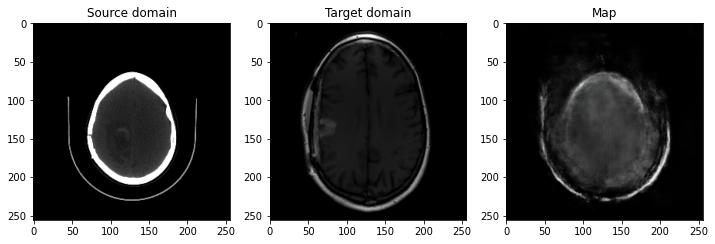

In [69]:
for epoch in range(Epochs):
    start = time.time()
    i = 0
    print ('\nEpoch {}/{} '.format(epoch+1, Epochs))
    for img_a, img_b in train_dataset:
        
        train_discriminator(img_a, img_b)
        train_generator(img_a, img_b)
        
        percent = float(i+1) * 100 / len(train_dataset)
        arrow   = '-' * int(percent/100 * 10 - 1) + '>'
        spaces  = ' ' * (10 - len(arrow))
        print('\rTraining: [%s%s] %d %% '% (arrow, spaces, percent), end='', flush=True)
        i += 1
    print(" -", int(time.time()-start), "s", end="")
    print()
    
    if (epoch+1)%5==0:
        cache = image_show()